In [1]:
import numpy as np
import scipy.signal as sig
import imageio
import matplotlib.pyplot as plt

In [2]:
def ricker_wavelet(points, a):
    """Genera una wavelet de Ricker (Mexican hat) para simular pulso ultrasónico."""
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = a**2
    x = np.linspace(-points/2, points/2, points)
    return A * (1 - (x**2/wsq)) * np.exp(-x**2/(2*wsq))

def simulate_echo(image_path, fs=50e6, fc=15e6, c=1540, dz=0.05e-3, snr_db=20):
    """
    Simula eco ultrasónico a partir de una imagen de huella.
    
    Args:
        image_path: ruta a la imagen en escala de grises.
        fs: frecuencia de muestreo (Hz).
        fc: frecuencia de portadora (Hz).
        c: velocidad del sonido en tejido (m/s).
        dz: espesor de cada píxel (m).
        snr_db: relación señal/ruido deseada (dB).
    Returns:
        t: vector de tiempos.
        echo: señal simulada con ruido.
    """
    # Carga la imagen y normaliza amplitudes
    img = imageio.imread(image_path).astype(np.float32) / 255.0
    nz, nx = img.shape

    # Diseña pulso: Ricker wavelet modulada en fc
    pts = int(fs / fc * 6)  # ~6 ciclos
    w = ricker_wavelet(pts, a=2.0)
    t_w = np.arange(pts) / fs
    carrier = np.cos(2*np.pi*fc*t_w)
    pulse = sig.convolve(w, carrier, mode='same')  # pulso banda ancha

    # Tiempo máximo según profundidad
    max_depth = nz * dz
    t_max = 2 * max_depth / c
    nt = int(t_max * fs) + pts

    echoes = np.zeros((nx, nt))  # nx columnas, nt muestras por eco
    for j in range(nx):
        for i in range(nz):
            amp = img[i, j]
            t_delay = 2 * (i * dz) / c
            idx = int(t_delay * fs)
            echoes[j, idx:idx+pts] += amp * pulse

    # Añade ruido blanco según SNR
    # power_signal = np.mean(echo**2)
    # power_noise = power_signal / (10**(snr_db/10))
    # noise = np.sqrt(power_noise) * np.random.randn(nt)
    # echo_noisy = echo + noise  # añade ruido realista

    t = np.arange(nt) / fs
    return t, echoes

In [3]:
img_path = "105_2.tif"
t, echoes = simulate_echo(img_path)

/tmp/ipykernel_130623/3366952183.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path).astype(np.float32) / 255.0
/tmp/ipykernel_130623/3366952183.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = imageio.imread(image_path).astype(np.float32) / 255.0


/tmp/ipykernel_130623/1635853409.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


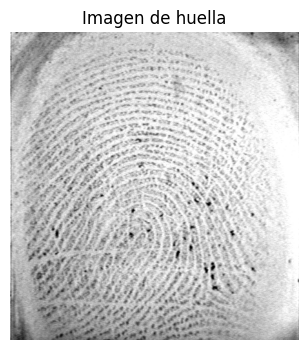

In [4]:
# Visualiza la imagen original
img = imageio.imread(img_path)
plt.figure(figsize=(8,4))
plt.imshow(img, cmap='gray')
plt.title("Imagen de huella")
plt.axis('off')
plt.show()

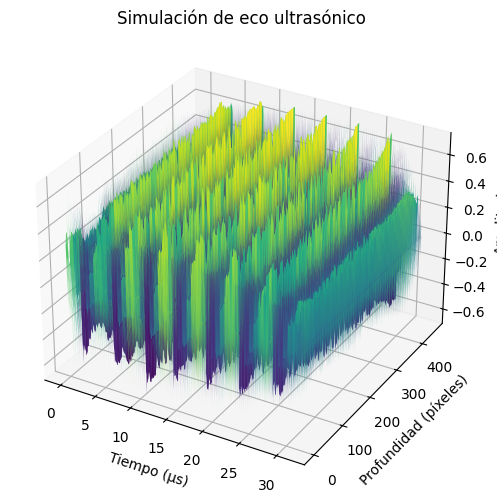

In [5]:
# Plot 3D de la señal
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(t*1e6, np.arange(echoes.shape[0]))
ax.plot_surface(X, Y, echoes, cmap='viridis')
ax.set_xlabel('Tiempo (µs)')
ax.set_ylabel('Profundidad (píxeles)')
ax.set_zlabel('Amplitud')
ax.set_title('Simulación de eco ultrasónico')
plt.show()